CVXPY是一个用于凸优化问题的Python嵌入式建模语言。 它会自动将问题转换为标准形式，调用求解器并解开结果。

下面的代码解决了CVXPY中的一个简单的优化问题：

In [1]:
import cvxpy as cvx

# Create two scalar optimization variables.
x = cvx.Variable()
y = cvx.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cvx.Minimize((x - y)**2)

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


“最优”的状态告诉我们问题已成功解决。最优值（这里基本上是1）是满足约束的目标其最小值。最后打印给出取得最优目标的x和y值(分别为1和0)。

`prob.solve()`返回最优值,并更新问题中的所有变量的`prob.status`，`prob.value`和`value`字段。

# 改变问题

`Problems`是不可改变的，这意味着它们在创建后无法更改。要改变目标或约束，请创建一个新问题。

In [2]:
# Replace the objective.
prob2 = cvx.Problem(cvx.Maximize(x + y), prob.constraints)
print("optimal value", prob2.solve())

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob.constraints[1:]
prob2 = cvx.Problem(prob.objective, constraints)
print("optimal value", prob2.solve())

optimal value 0.9996939016105757
optimal value 1.0


# 不可行和无界的问题

如果问题不可行或无界，状态字段将分别设置为“不可行”或“无界”。 问题变量的值字段未更新。

In [3]:
import cvxpy as cvx

x = cvx.Variable()

# An infeasible problem.
prob = cvx.Problem(cvx.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

# An unbounded problem.
prob = cvx.Problem(cvx.Minimize(x))
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: infeasible
optimal value inf
status: unbounded
optimal value -inf


请注意，对于最小化问题，如果不可行，最优值将为inf，如果无界为-inf。 对于最大化问题，情况恰恰相反。

## 其他问题状态

如果由CVXPY调用的解算器解决了问题，但准确度低于所需的值，则问题状态表示实现的准确度较低。 表示较低准确度的状态是：

+ “optimal_inaccurate”
+ “unbounded_inaccurate”
+ “infeasible_inaccurate”

对于找到的解决方案类型（即，最优，无限或不可行），问题变量将照常更新。

如果解算器完全无法解决问题，则CVXPY将抛出`SolverError`异常。如果发生这种情况，你应该尝试使用其他求解器。 有关详细信息，请参阅[选择求解器](http://www.cvxpy.org/tutorial/advanced/index.html#solvers)的讨论。

CVXPY提供以下常量作为不同状态字符串的别名：
+ OPTIMAL
+ INFEASIBLE
+ UNBOUNDED
+ OPTIMAL_INACCURATE
+ INFEASIBLE_INACCURATE
+ UNBOUNDED_INACCURATE

例如，要测试问题是否成功解决，您可以使用

In [4]:
prob.status == cvx.OPTIMAL

False

# 矢量与矩阵

`Variables`可以是标量，矢量或矩阵，也就是说它们是0,1或2维。

In [5]:
# A scalar variable.
a = cvx.Variable()

# Vector variable with shape (5,).
x = cvx.Variable(5)

# Matrix variable with shape (5, 1).
x = cvx.Variable((5, 1))

# Matrix variable with shape (4, 7).
A = cvx.Variable((4, 7))

你可以使用你选择的数字库来构造矩阵和向量常量。例如，如果`x`是表达式`A * x + b`中的一个CVXPY变量，则`A`和`b`可以是Numpy，Ruby，SciPy稀疏矩阵等.`A`和`b`甚至可以是不同的类型。

目前，以下类型可以用作常量：
+ NumPy ndarrays
+ NumPy matrices
+ SciPy sparse matrices

下面是向量和矩阵的CVXPY问题的一个例子：

In [6]:
# Solves a bounded least-squares problem.

import cvxpy as cvx
import numpy

# Problem data.
m = 10
n = 5
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cvx.Variable(n)
objective = cvx.Minimize(cvx.sum_squares(A*x - b))
constraints = [0 <= x, x <= 1]
prob = cvx.Problem(objective, constraints)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

Optimal value 4.141338603672536
Optimal var
[-4.80085741e-21  5.90994300e-21  1.34643668e-01  1.24976681e-01
 -4.69974639e-21]


# `限定`(`Constraints`)

如示例代码所示，可以使用`==`，`<=`和`>=`在CVXPY中构造约束。等于和不等于约束是元素的，无论它们涉及标量，向量还是矩阵。 例如，`0 <= x`和`x <= 1`意味着x的每个条目都在0和1之间。

如果想要表示半定锥体约束的矩阵不等式，请参阅[半定矩阵](http://www.cvxpy.org/tutorial/advanced/index.html#semidefinite)。此部分解释如何表达半定锥不等式。

你不能用`<`和`>`构造不等式。严格的不等在现实世界中是没有意义的。此外，您不能将约束链接在一起，例如`0 <= x <= 1`或`x == y == 2`。Python解释器以此方式处理链式约束，而CVXPY无法捕获。如果您编写链式约束，CVXPY将引发异常。

# `参数`(`Parameters`)

**Parameters**是常量的符号表示。 参数的目的是在不重构整个问题的情况下改变问题中常量的值。

参数可以是矢量或矩阵，就像变量一样。创建参数时，您可以选择指定属性，如参数实体的符号，参数是否对称等。这些属性用于[Disciplined Convex Programming](http://www.cvxpy.org/tutorial/dcp/index.html#dcp)中，除非指定，否则它们是未知的。参数可以在创建后随时分配一个常量值。常量值的维度和属性必须与创建参数时指定的维度和属性相同。

In [7]:
# Positive scalar parameter.
m = cvx.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cvx.Parameter(5)

# Matrix parameter with negative entries.
G = cvx.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -numpy.ones((4, 7))

你可以用一个值初始化一个参数。 以下代码段是等效的：

In [8]:
# Create parameter, then assign value.
rho = cvx.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cvx.Parameter(nonneg=True, value=2)

参数在计算折衷曲线中很常见。下面的例子计算了LASSO问题的权衡曲线。

In [9]:
%matplotlib inline

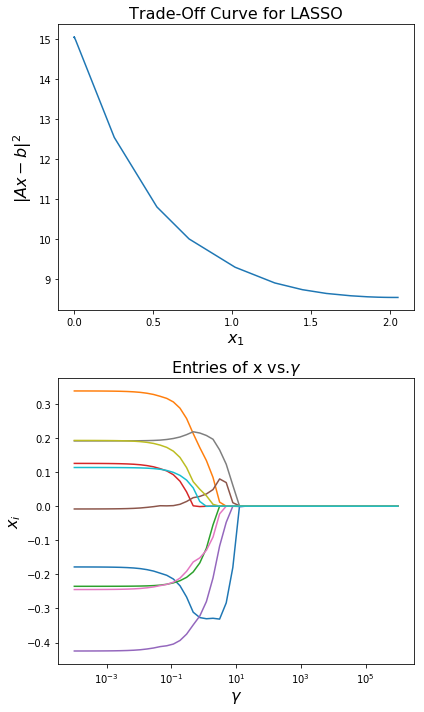

In [10]:
import cvxpy as cvx
import numpy
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10
numpy.random.seed(1)
A = numpy.random.randn(n, m)
b = numpy.random.randn(n)
# gamma must be nonnegative due to DCP rules.
gamma = cvx.Parameter(nonneg=True)

# Construct the problem.
x = cvx.Variable(m)
error = cvx.sum_squares(A*x - b)
obj = cvx.Minimize(error + gamma*cvx.norm(x, 1))
prob = cvx.Problem(obj)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []
gamma_vals = numpy.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cvx.norm(x, 1).value)
    x_values.append(x.value)

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.figure(figsize=(6,10))

# Plot trade-off curve.
plt.subplot(211)
plt.plot(l1_penalty, sq_penalty)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$|Ax-b\|^2$', fontsize=16)
plt.title('Trade-Off Curve for LASSO', fontsize=16)

# Plot entries of x vs. gamma.
plt.subplot(212)
for i in range(m):
    plt.plot(gamma_vals, [xi[i] for xi in x_values])
plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('$x_i$', fontsize=16)
plt.xscale('log')
plt.title('Entries of x vs.$\gamma$', fontsize=16)

plt.tight_layout()
plt.show()

In [37]:
prob.solver_stats.solver_name

'OSQP'

权衡曲线可以很容易地并行计算。 以下代码并行计算上面LASSO问题中每个`γ`的最优`x`。

In [11]:
from multiprocessing import Pool

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    result = prob.solve()
    return x.value

# Parallel computation (set to 1 process here).
pool = Pool(processes = 1)
x_values = pool.map(get_x, gamma_vals)